### Supermarket Simulation Using Markov Chains

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

### 1. EDA

In [2]:
monday = pd.read_csv('_RES/monday.csv', sep=';')

In [3]:
monday.shape

(4884, 3)

In [4]:
monday.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


In [5]:
monday.tail()

,timestamp,customer_no,location
4879,2019-09-02 21:49:00,1442,checkout
4880,2019-09-02 21:49:00,1444,checkout
4881,2019-09-02 21:49:00,1445,dairy
4882,2019-09-02 21:50:00,1446,dairy
4883,2019-09-02 21:50:00,1447,fruit


In [6]:
monday.describe()

,customer_no
count,4884.000000
mean,718.274365
std,411.839636
min,1.000000
25%,366.000000
50%,720.000000
75%,1070.000000
max,1447.000000


In [7]:
monday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    4884 non-null   object
 1   customer_no  4884 non-null   int64 
 2   location     4884 non-null   object
dtypes: int64(1), object(2)
memory usage: 114.6+ KB


#### Create datetime index

In [8]:
datetime = pd.to_datetime(monday['timestamp'])
monday.index = pd.DatetimeIndex(datetime)
monday = monday.drop(['timestamp'], axis=1)

In [9]:
monday.head()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices


#### Calculate the total number of customers in each section

In [10]:
monday.groupby(by=['location']).nunique()

,customer_no,location
location,,
checkout,1437,1
dairy,720,1
drinks,661,1
fruit,827,1
spices,584,1


#### Calculate the total number of customers in each section over time

Showing how many customers are present on how many locations over time

In [11]:
monday.groupby(by=['timestamp']).nunique()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,2,1
2019-09-02 07:04:00,6,3
2019-09-02 07:05:00,4,3
2019-09-02 07:06:00,8,5
2019-09-02 07:07:00,4,4
...,...,...
2019-09-02 21:46:00,6,4
2019-09-02 21:47:00,6,3
2019-09-02 21:48:00,7,4


Showing how many customers are present at individual locations over time

In [12]:
monday.groupby(['timestamp', 'location']).count().unstack(level=1).fillna(0)

customer_no                          
location               checkout dairy drinks fruit spices
timestamp                                                
2019-09-02 07:03:00         0.0   2.0    0.0   0.0    0.0
2019-09-02 07:04:00         0.0   2.0    0.0   1.0    3.0
2019-09-02 07:05:00         2.0   1.0    1.0   0.0    0.0
2019-09-02 07:06:00         2.0   2.0    1.0   2.0    1.0
2019-09-02 07:07:00         1.0   1.0    1.0   0.0    1.0
...                         ...   ...    ...   ...    ...
2019-09-02 21:46:00         1.0   0.0    2.0   1.0    2.0
2019-09-02 21:47:00         2.0   2.0    0.0   2.0    0.0
2019-09-02 21:48:00         2.0   2.0    2.0   0.0    1.0
2019-09-02 21:49:00         2.0   1.0    0.0   2.0    2.0
2019-09-02 21:50:00         0.0   1.0    0.0   1.0    0.0

[874 rows x 5 columns]

Showing grouped information on location over time for individual customers

In [13]:
monday.groupby(['customer_no', 'timestamp']).sum()

location
customer_no timestamp                    
1           2019-09-02 07:03:00     dairy
            2019-09-02 07:05:00  checkout
2           2019-09-02 07:03:00     dairy
            2019-09-02 07:06:00  checkout
3           2019-09-02 07:04:00     dairy
...                                   ...
1444        2019-09-02 21:48:00    spices
            2019-09-02 21:49:00  checkout
1445        2019-09-02 21:49:00     dairy
1446        2019-09-02 21:50:00     dairy
1447        2019-09-02 21:50:00     fruit

[4884 rows x 1 columns]

#### Upsampling Customers
There are missing values for some customers at specific times, which can be forward filled (assuming they've always just stayed at the previous location)

In [23]:
monday_filled = monday.groupby('customer_no').resample('T').ffill()

In [27]:
monday_filled.drop('customer_no', axis=1, inplace=True)

In [30]:
monday_filled = monday_filled.reset_index().set_index('timestamp')

In preparation for the plotting, downsample the data to display total hourly count and get unique values to get rid off duplicates

In [93]:
monday_filled['duplicate'] = monday_filled.duplicated(['customer_no', 'location'])
monday_filled.head(10)

,customer_no,location,duplicate
timestamp,,,
2019-09-02 07:03:00,1,dairy,False
2019-09-02 07:04:00,1,dairy,True
2019-09-02 07:05:00,1,checkout,False
2019-09-02 07:03:00,2,dairy,False
2019-09-02 07:04:00,2,dairy,True
2019-09-02 07:05:00,2,dairy,True
2019-09-02 07:06:00,2,checkout,False
2019-09-02 07:04:00,3,dairy,False
2019-09-02 07:05:00,3,dairy,True


In [97]:
monday_filled[monday_filled['duplicate'] == False]

,customer_no,location,duplicate
timestamp,,,
2019-09-02 07:03:00,1,dairy,False
2019-09-02 07:05:00,1,checkout,False
2019-09-02 07:03:00,2,dairy,False
2019-09-02 07:06:00,2,checkout,False
2019-09-02 07:04:00,3,dairy,False
...,...,...,...
2019-09-02 21:48:00,1444,spices,False
2019-09-02 21:49:00,1444,checkout,False
2019-09-02 21:49:00,1445,dairy,False


In [110]:
monday_filled.drop('duplicate', axis=1).groupby(['timestamp', 'location']).count().unstack(level=1).resample('H').count()

customer_no                          
location               checkout dairy drinks fruit spices
timestamp                                                
2019-09-02 07:00:00          50    57     53    54     37
2019-09-02 08:00:00          52    59     52    58     41
2019-09-02 09:00:00          43    59     57    58     42
2019-09-02 10:00:00          46    59     49    57     41
2019-09-02 11:00:00          36    56     38    48     33
2019-09-02 12:00:00          44    57     52    54     45
2019-09-02 13:00:00          54    60     57    58     50
2019-09-02 14:00:00          46    59     44    56     43
2019-09-02 15:00:00          47    60     51    55     47
2019-09-02 16:00:00          43    50     54    54     37
2019-09-02 17:00:00          53    59     57    60     43
2019-09-02 18:00:00          55    60     59    60     51
2019-09-02 19:00:00          54    59     57    55     50
2019-09-02 20:00:00          46    59     60    57     46
2019-09-02 21:00:00          31    36     35    36     27

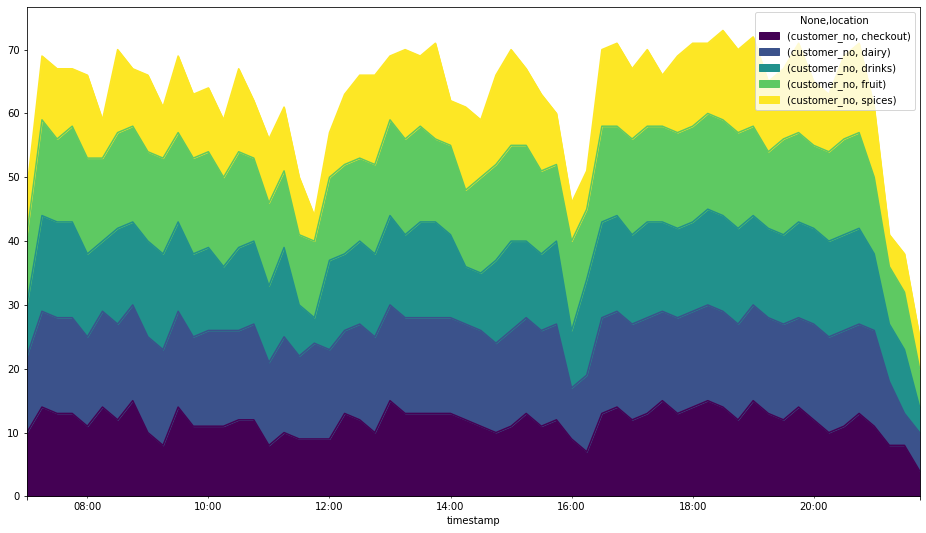

In [112]:
monday_filled.drop('duplicate', axis=1).groupby(['timestamp', 'location']).count().unstack(level=1).resample('15T').count().plot.area(cmap='viridis')
plt.gcf().set_size_inches(16, 9)

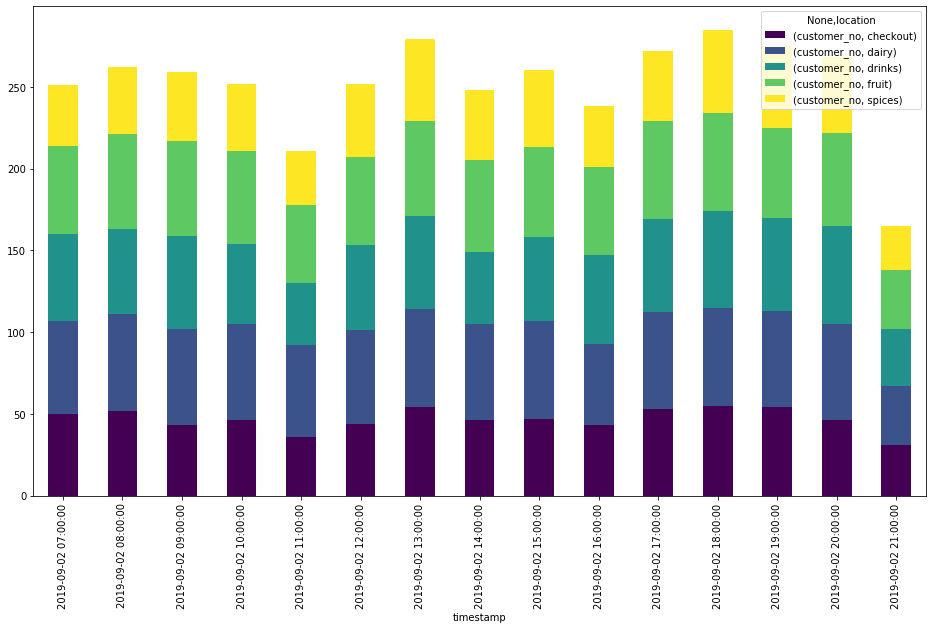

In [116]:
monday_filled.drop('duplicate', axis=1).groupby(['timestamp', 'location']).count().unstack(level=1).resample('H').count().plot.bar(stacked=True, cmap='viridis')
plt.gcf().set_size_inches(16, 9)

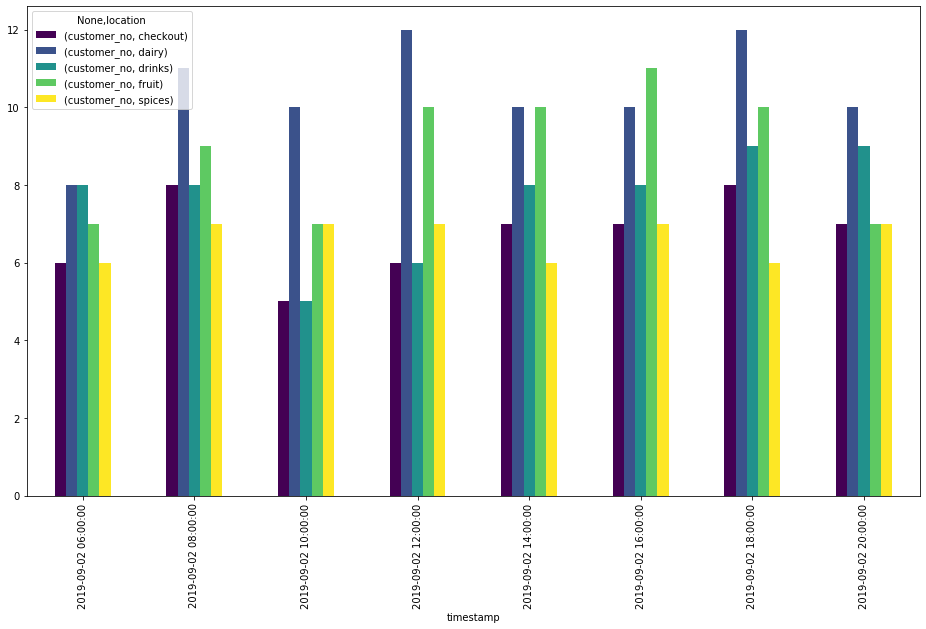

In [47]:
monday_filled.groupby(['timestamp', 'location']).count().unstack(level=1).resample('2H').nunique().plot.bar(cmap='viridis')
plt.gcf().set_size_inches(16, 9)

#### Display the number of customers at checkout over time

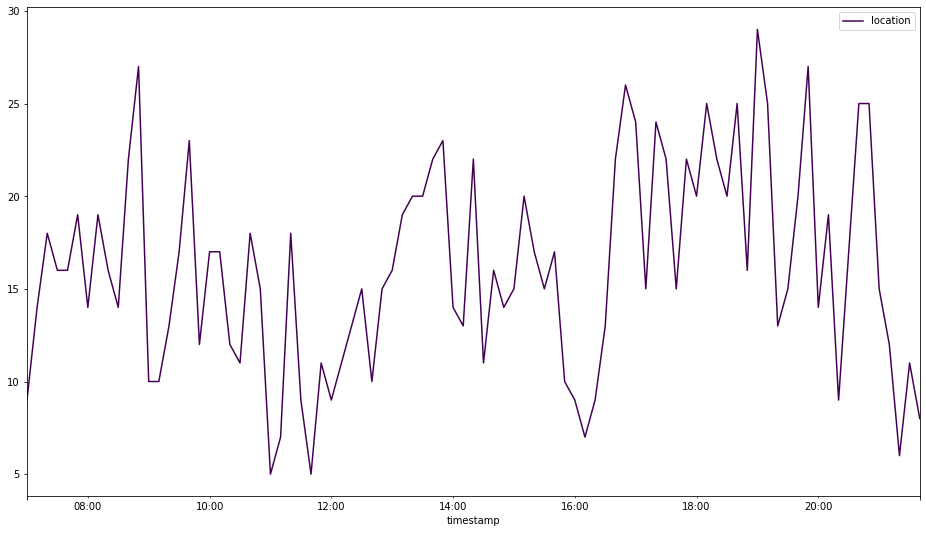

In [83]:
monday_filled[monday_filled['location'] == 'checkout'].resample('10T').count().plot(y='location', cmap='viridis')
plt.gcf().set_size_inches(16, 9)

#### Calculate the time each customer spent in the market

#### Calculate the total number of customers present in the supermarket over time.

#### Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).